Made a copy to go back and fix some data errors and improve the data processing, but it changed the analysis results too much. Maybe I'll rework the rest later!

### Project Overview
This analysis of movie data, sourced from Kaggle, The Numbers, and IMDb, investigates the financial success of movies by analyzing the risk-reward relationship between production budget and profitability, adjusted to the yearly Consumer Price Index. This analysis leverages historical movie data to identify patterns and key features, such as genres, directors, and number of principals, that correlate with higher profitability. By applying statistical techniques like ANOVA and linear regression, the project uncovers which genres and budget categories lead to the most successful movies. Additionally, the project offers recommendations for future movie production, focusing on maximizing ROI based on these identified success factors.

### Business Problem
The movie industry operates in a highly competitive environment where production companies aim to maximize profitability while minimizing financial risk. However, predicting the financial success of a movie is challenging due to various factors like genre, budget, cast, and market trends. This project seeks to address this uncertainty by identifying the key features that drive higher returns on investment (ROI) for movies. The goal is to provide movie studios and producers with actionable insights to optimize their budgets and make informed decisions about which genres, directors, and budget levels are more likely to result in profitable outcomes. By analyzing historical data, the project can help studios focus their resources on the most promising projects, thereby improving financial performance in an unpredictable market.

## Data Understanding

Project data sources:

* [IMDb](https://www.imdb.com/)
* [The Numbers](https://www.the-numbers.com/)
* [Kaggle - The Ultimate Film Statistics Dataset](https://www.kaggle.com/datasets/alessandrolobello/the-ultimate-film-statistics-dataset-for-ml/data)
* [US Bureau of Labor Statistics](https://www.bls.gov/)

All datasets used in this analysis are available in the zipped Data file - just unzip in place to use our project. The unzipped folder is already added to the .gitignore to avoid errors with trying to upload the large IMDb sqlite database file to GitHub.

This project combines movie budget and earnings sourced from Kaggle and The Numbers with an IMDb dataset of production elements to create a feature-rich list of over 5700 movies with financial metrics, using historical Consumer Price Index (CPI) tables from the US Bureau of Labor Statistics to adjust dollar values for inflation. Key data fields include genres, production budgets, domestic and worldwide gross earnings, and director. The project focuses on maximizing ROI to evaluate the financial success of movies, while accounting for risk as determined by production budget.

When evaluating the following recommendations, it is crucial to keep in mind that our data can *only* account for projects that actually survive to release and distribution. This analysis can help inform what projects to pursue, but none of this - aside, possibly, from director selection - is relevant to the task of assuring that a film actually comes to fruition.

#### Source Details

The Kaggle dataset has detailed financial and production information for movies, which is up-to-date and suitable for analysis. 

The Numbers is an online movie database service. The dataset from them is somewhat outdated but reasonably large. It incorporates few features but provides comprehensive budget and gross earnings data.

Consumer Price Index (CPI) Tables sourced from the US Bureau of Labor Statistics are used to adjust financial data for inflation, ensuring all monetary figures are standardized over time.

IMDb SQLite3 database is a rich and comprehensive source of movie features for analysis. However, it lacks financial metrics for evaluating movie success. It is structured as follows:

![ERD showing primary datasets "movie_basics" and "persons" with tables of relationships between movies and persons and some additional movie data tables](images\movie_data_erd.jpeg)

In [111]:
# Importing several standard modules in our Preparation and Analysis
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.ticker as mtick

In [112]:
#Connecting to our IMDB Sqlite database file
con = sqlite3.connect('Data/im.db')

In [113]:
#Use Pandas to quickly validate EDA information
pd.read_sql('''

SELECT *
FROM sqlite_master

''', con)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [114]:
pd.read_sql('''

SELECT *
FROM movie_basics
LIMIT 15
        
''', con)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller"
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy"
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History"
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography


### Data Preparation

In our project, data preparation was a key step to ensure accurate analysis.

We addressed missing values, removed duplicates, and ensured data consistency across all relevant fields.
We merged datasets (movies, directors, and others) based on movie_id and person_id to consolidate essential information like gross earnings, genres, and director details.
Handling Multi-Genres: We split multi-genre entries to analyze each genre's impact separately on metrics like ROI.
We normalized ROI by considering production budgets and gross earnings adjusted for inflation. We created new features like approval index and normalized budgets to improve insights.We filtered directors based on relevant criteria such as age and status (alive) for modern analysis.

In [115]:
# Reading in financial data csvs
tn_data = pd.read_csv('Data/tn.movie_budgets.csv')
kaggle_data = pd.read_csv('Data/movie_statistic_dataset.csv')
inflation_data  = pd.read_csv('Data/US_CPI.csv')

# Reading in IMDB movie basics
imdb_data = pd.read_sql('''
                        SELECT * 
                        FROM movie_basics
                            JOIN directors USING(movie_id)
                            JOIN persons USING(person_id)
                            JOIN movie_ratings USING(movie_id)
                        
                        ''', con)

# We investigated whether data from Box Office Mojo could fill in missing data from The Numbers, it did not turn out to be relevant.
bom_data = pd.read_csv('Data/bom.movie_gross.csv')

In [116]:
# Financial data in TN dataset was a string with $#,###,### format
# converts monetary values in the dataset from strings to floats
tn_data['production_budget'] = tn_data['production_budget'].str.replace('$', '').str.replace(',', '').astype(float)
tn_data['domestic_gross'] = tn_data['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(float)
tn_data['worldwide_gross'] = tn_data['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)


In [117]:
tn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   float64
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 271.2+ KB


In [118]:
# Filtering tn_data to ensure we have the production budget
tn_data = tn_data[tn_data['production_budget'] != 0]

In [119]:
# Merging tn_data with bom_data, which has revenue but not budget
tn_and_bom = tn_data.merge(bom_data, left_on='movie', right_on='title', how='left')

In [120]:
# the bom_data apparently only contains information for 4 movies that are not already in the tn_data. 
# (3 when you notice one is a remake.)
# BOM data can be safely disregarded.
tn_and_bom[(tn_and_bom['domestic_gross_x']==0) & (tn_and_bom['worldwide_gross']==0) & ((tn_and_bom['domestic_gross_y'].notnull()) | (tn_and_bom['foreign_gross'].notnull()))]

,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,title,studio,domestic_gross_y,foreign_gross,year
4768,69,"Sep 18, 1967",Point Blank,3000000.0,0.0,0.0,Point Blank,Magn.,708000.0,8500000,2011.0
4865,66,"Jan 19, 2016",Eden,2300000.0,0.0,0.0,Eden,BG,65500.0,NaN,2015.0
5330,31,"Dec 31, 2012",Trance,950000.0,0.0,0.0,Trance,FoxS,2300000.0,21900000,2013.0
5351,52,"Dec 31, 2012",Snitch,850000.0,0.0,0.0,Snitch,LG/S,42900000.0,NaN,2013.0


In [121]:
# filtering the dataset (tn_data) to remove any records where we don't have revenue.
tn_data = tn_data.loc[(tn_data['domestic_gross'] != 0) | (tn_data['worldwide_gross'] != 0)]

In [122]:
# Now to enhance compatibility between Kaggle dataset and TN by formatting dates and standardizing column names
tn_data = tn_data.rename(columns={'movie':'movie_title','release_date':'production_date'})
tn_data['production_date'] = pd.to_datetime(tn_data['production_date']).dt.year.astype(int)

kaggle_data['production_date'] = pd.to_datetime(kaggle_data['production_date']).dt.year.astype(int)

In [123]:
# prior to merge we have 5415 films from TN and 4380 films from Kaggle.
tn_data.info(), kaggle_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5415 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5415 non-null   int64  
 1   production_date    5415 non-null   int32  
 2   movie_title        5415 non-null   object 
 3   production_budget  5415 non-null   float64
 4   domestic_gross     5415 non-null   float64
 5   worldwide_gross    5415 non-null   float64
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 275.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_title           4380 non-null   object 
 1   production_date       4380 non-null   int32  
 2   genres                4380 non-null   object 
 3   runtime_minutes       4380 non-null   float64
 4   director_name         4

(None, None)

In [124]:
# combining data from the two different sources (kaggle_data and tn_data) to form a comprehensive dataset, 
# which includes movie titles, production budgets, and gross earnings from both datasets.
money_data = kaggle_data.merge(tn_data, on=['movie_title','production_date'], how='outer')

In [125]:
# Shows that aligning on title and year was successful.
money_data.head(10)

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,id,production_budget,domestic_gross,worldwide_gross
0,(500) Days of Summer,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,7500000.0,32425665.0,34439060.0
1,10 Cloverfield Lane,2016,"Drama,Horror,Mystery",103.0,Dan Trachtenberg,"music_department,director,writer",\N,alive,7.2,333495.0,6.605087,15000000.0,72082999.0,108286422.0,54.0,5000000.0,72082999.0,108286422.0
2,10 Days in a Madhouse,2015,Drama,111.0,Timothy Hines,"visual_effects,director,writer",1960,alive,5.8,2797.0,3.254874,12000000.0,14616.0,14616.0,48.0,12000000.0,14616.0,14616.0
3,10 Things I Hate About You,1999,"Comedy,Drama,Romance",97.0,Gil Junger,"producer,director,miscellaneous",1954,alive,7.3,349513.0,6.723852,13000000.0,38177966.0,60413950.0,63.0,13000000.0,38177966.0,60413950.0
4,"10,000 B.C.",2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,105000000.0,94784201.0,269065678.0
5,102 Dalmatians,2000,"Adventure,Comedy,Family",100.0,Kevin Lima,"animation_department,director,producer",1962,alive,4.8,38163.0,3.593880,85000000.0,66941559.0,66941559.0,6.0,85000000.0,66941559.0,66941559.0
6,10th & Wolf,2006,"Crime,Drama,Thriller",107.0,Bobby Moresco,"producer,writer,director",1951,alive,6.3,6641.0,3.947646,8000000.0,54702.0,143782.0,32.0,8000000.0,54702.0,143782.0
7,12 Monkeys,1995,"Mystery,Sci-Fi,Thriller",129.0,Terry Gilliam,"writer,actor,animation_department",1940,alive,8.0,622758.0,7.721232,29000000.0,57141459.0,168841459.0,18.0,29000000.0,57141459.0,168841459.0
8,12 Rounds,2009,"Action,Crime,Thriller",108.0,Renny Harlin,"producer,director,writer",1959,alive,5.6,29457.0,4.108146,20000000.0,12234694.0,17306648.0,37.0,20000000.0,12234694.0,17306648.0
9,12 Strong,2018,"Action,Drama,History",130.0,Nicolai Fuglsig,"director,writer,producer",1972,alive,6.5,84041.0,5.290942,35000000.0,45819713.0,71118378.0,64.0,35000000.0,45819713.0,71118378.0


In [126]:
money_data.tail(10)

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,id,production_budget,domestic_gross,worldwide_gross
5839,Zwartboek,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,22000000.0,4398532.0,27238354.0
5840,[Rec],2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.0,2100000.0,0.0,23266821.0
5841,[Rec] 2,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,5600000.0,27766.0,18527766.0
5842,crazy/beautiful,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,13000000.0,16929123.0,19929123.0
5843,eXistenZ,1999,"Horror,Mystery,Sci-Fi",97.0,David Cronenberg,"actor,director,writer",1943,alive,6.8,102151.0,5.638858,20700000.0,2840417.0,2840417.0,83.0,20700000.0,2840417.0,2840417.0
5844,mother!,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,30000000.0,17800004.0,42531076.0
5845,xXx,2002,"Action,Adventure,Thriller",124.0,Rob Cohen,"producer,director,actor",1949,alive,5.8,181595.0,5.035740,70000000.0,141930000.0,267200000.0,98.0,70000000.0,141930000.0,267200000.0
5846,xXx: Return of Xander Cage,2017,"Action,Adventure,Thriller",107.0,D.J. Caruso,"director,producer,writer",1965,alive,5.2,93427.0,4.246895,85000000.0,44898413.0,345033359.0,15.0,85000000.0,44898413.0,345033359.0
5847,Ã l\'intÃ©rieur,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,3000000.0,0.0,895932.0
5848,é·æ±ä¸è (CJ7),2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,20000000.0,206678.0,47300771.0


In [127]:
# We see that we now have 5849 films with financial data. 
# Kaggle data appears to be preserved exactly (4380 entries) 
# but it looks like TN now has some duplicated entries (5464 entries, up from 5415, which means there were existing dupes in kaggle) 
money_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5849 entries, 0 to 5848
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_title           5849 non-null   object 
 1   production_date       5849 non-null   int32  
 2   genres                4380 non-null   object 
 3   runtime_minutes       4380 non-null   float64
 4   director_name         4380 non-null   object 
 5   director_professions  4380 non-null   object 
 6   director_birthYear    4380 non-null   object 
 7   director_deathYear    4380 non-null   object 
 8   movie_averageRating   4380 non-null   float64
 9   movie_numerOfVotes    4380 non-null   float64
 10  approval_Index        4380 non-null   float64
 11  Production budget $   4380 non-null   float64
 12  Domestic gross $      4380 non-null   float64
 13  Worldwide gross $     4380 non-null   float64
 14  id                    5464 non-null   float64
 15  production_budget    

In [128]:
# drop duplicates
money_data = money_data.drop_duplicates(['movie_title','production_date'])

In [129]:
# better!
money_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5785 entries, 0 to 5848
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_title           5785 non-null   object 
 1   production_date       5785 non-null   int32  
 2   genres                4316 non-null   object 
 3   runtime_minutes       4316 non-null   float64
 4   director_name         4316 non-null   object 
 5   director_professions  4316 non-null   object 
 6   director_birthYear    4316 non-null   object 
 7   director_deathYear    4316 non-null   object 
 8   movie_averageRating   4316 non-null   float64
 9   movie_numerOfVotes    4316 non-null   float64
 10  approval_Index        4316 non-null   float64
 11  Production budget $   4316 non-null   float64
 12  Domestic gross $      4316 non-null   float64
 13  Worldwide gross $     4316 non-null   float64
 14  id                    5415 non-null   float64
 15  production_budget     5415

In [130]:
# Handling missing values and filling in the gaps in our merged dataset (money_data)
# Any gaps in financial data from one dataset (Kaggle or The Numbers) are filled in by the other, retaining as much financial information as possible

money_data['Production budget $'].fillna(money_data['production_budget'], inplace=True)
money_data['Domestic gross $'].fillna(money_data['domestic_gross'], inplace=True)
money_data['Worldwide gross $'].fillna(money_data['worldwide_gross'], inplace=True)
money_data.rename(columns={'production_date':'year'}, inplace=True)
print(money_data.head())

                  movie_title  year                genres  runtime_minutes  \
0        (500) Days of Summer  2009                   NaN              NaN   
1         10 Cloverfield Lane  2016  Drama,Horror,Mystery            103.0   
2       10 Days in a Madhouse  2015                 Drama            111.0   
3  10 Things I Hate About You  1999  Comedy,Drama,Romance             97.0   
4                 10,000 B.C.  2008                   NaN              NaN   

      director_name              director_professions director_birthYear  \
0               NaN                               NaN                NaN   
1  Dan Trachtenberg  music_department,director,writer                 \N   
2     Timothy Hines    visual_effects,director,writer               1960   
3        Gil Junger   producer,director,miscellaneous               1954   
4               NaN                               NaN                NaN   

  director_deathYear  movie_averageRating  movie_numerOfVotes  approval_In

C:\Users\erica\AppData\Local\Temp\ipykernel_14780\2454125684.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  money_data['Production budget $'].fillna(money_data['production_budget'], inplace=True)
C:\Users\erica\AppData\Local\Temp\ipykernel_14780\2454125684.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

In [131]:
#Seeing that our combined data is complete for date and financial data. 
print(money_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5785 entries, 0 to 5848
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_title           5785 non-null   object 
 1   year                  5785 non-null   int32  
 2   genres                4316 non-null   object 
 3   runtime_minutes       4316 non-null   float64
 4   director_name         4316 non-null   object 
 5   director_professions  4316 non-null   object 
 6   director_birthYear    4316 non-null   object 
 7   director_deathYear    4316 non-null   object 
 8   movie_averageRating   4316 non-null   float64
 9   movie_numerOfVotes    4316 non-null   float64
 10  approval_Index        4316 non-null   float64
 11  Production budget $   5785 non-null   float64
 12  Domestic gross $      5785 non-null   float64
 13  Worldwide gross $     5785 non-null   float64
 14  id                    5415 non-null   float64
 15  production_budget     5415

#### Next step: Derived financial data - costs and gross adjusted to year

Understanding that dollar amounts do not directly correlate to actual value, this adjustment will ensure that all financial metrics are comparable across different time periods.

Preparing to adjust the costs and gross revenue data for inflation by using the Consumer Price Index (CPI) from the inflation_data DataFrame. The output of inflation_data.head() shows the structure of your CPI dataset.

In [132]:
inflation_data.head()

,Yearmon,CPI
0,01-01-1913,9.8
1,01-02-1913,9.8
2,01-03-1913,9.8
3,01-04-1913,9.8
4,01-05-1913,9.7


By selecting only December CPI values, we  ensure that inflation adjustments are based on a consistent point in each year, reducing variability within the year and allowing that the year of production/release is not usually the primary year of earnings, so the latest CPI attached to the production year is more accurate. 

In [133]:
#Convert Yearmon to datetime
inflation_data['Yearmon'] = pd.to_datetime(inflation_data['Yearmon'], errors='coerce')

# Filter the CPI values for December of each year.
# datetime incorrectly guessed 12 days in january per year rather than 1st day of 12 months, so "day" 12.
CPI_by_year = inflation_data[inflation_data['Yearmon'].dt.day == 12] 

#Create Year column
CPI_by_year['year']=CPI_by_year['Yearmon'].dt.year

CPI_by_year.head()

C:\Users\erica\AppData\Local\Temp\ipykernel_14780\3750115127.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPI_by_year['year']=CPI_by_year['Yearmon'].dt.year


,Yearmon,CPI,year
11,1913-01-12,10.0,1913
23,1914-01-12,10.1,1914
35,1915-01-12,10.3,1915
47,1916-01-12,11.6,1916
59,1917-01-12,13.7,1917


In [134]:
# Base year for inflation adjustment (choose the latest year in your dataset)
base_year = CPI_by_year['year'].max()
base_cpi = CPI_by_year[CPI_by_year['year'] == base_year]['CPI'].values[0]

# Merge inflation data with movie data
money_data = pd.merge(money_data, CPI_by_year, how='left', on='year')

# Adjust values
money_data['adjusted_production_budget'] = (money_data['Production budget $'] * base_cpi) / money_data['CPI']
money_data['adjusted_gross'] = (np.maximum(money_data['Worldwide gross $'], money_data['Domestic gross $']) * base_cpi) / money_data['CPI']

# Calculate ROI
money_data['ROI'] = (money_data['adjusted_gross'] - money_data['adjusted_production_budget']) / money_data['adjusted_production_budget']


# Drop unnecessary columns from the merge
money_data.drop(columns=['genres', 'runtime_minutes', 'director_name','director_professions','director_birthYear', 'director_deathYear', 
                         'movie_averageRating', 'movie_numerOfVotes','id','production_budget','domestic_gross','worldwide_gross',
                         'Yearmon','CPI'], inplace=True)

# Preview adjusted data
print(money_data.head())


                  movie_title  year  approval_Index  Production budget $  \
0        (500) Days of Summer  2009             NaN            7500000.0   
1         10 Cloverfield Lane  2016        6.605087           15000000.0   
2       10 Days in a Madhouse  2015        3.254874           12000000.0   
3  10 Things I Hate About You  1999        6.723852           13000000.0   
4                 10,000 B.C.  2008             NaN          105000000.0   

   Domestic gross $  Worldwide gross $  adjusted_production_budget  \
0        32425665.0         34439060.0                1.016073e+07   
1        72082999.0        108286422.0                1.817655e+07   
2           14616.0            14616.0                1.484291e+07   
3        38177966.0         60413950.0                2.259822e+07   
4        94784201.0        269065678.0                1.461214e+08   

   adjusted_gross       ROI  
0    4.665681e+07  3.591875  
1    1.312182e+08  6.219095  
2    1.807867e+04 -0.998782  
3 

In [141]:
#take care of dupes in our imdb data, but preserving multi-director dupes for now.
imdb_data = imdb_data.drop_duplicates(['movie_id','person_id'])

In [142]:
# a peek at the imdb data
imdb_data.head()

,movie_id,movie_title,original_title,year,runtime_minutes,genres,person_id,director_name,director_birth_year,director_death_year,primary_profession,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer",7.0,77
4,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",nm0002411,Mani Kaul,1944.0,2011.0,"director,writer,actor",7.2,43
5,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,nm0000080,Orson Welles,1915.0,1985.0,"actor,director,writer",6.9,4517
7,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",nm0611531,Hrishikesh Mukherjee,1922.0,2006.0,"director,editor,writer",6.1,13
8,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",nm0749914,Raoul Ruiz,1941.0,2011.0,"director,writer,producer",6.5,119


In [143]:
# that's a lot of movies
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86030 entries, 0 to 181386
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   movie_id             86030 non-null  object 
 1   movie_title          86030 non-null  object 
 2   original_title       86030 non-null  object 
 3   year                 86030 non-null  int64  
 4   runtime_minutes      77112 non-null  float64
 5   genres               85232 non-null  object 
 6   person_id            86030 non-null  object 
 7   director_name        86030 non-null  object 
 8   director_birth_year  24696 non-null  float64
 9   director_death_year  699 non-null    float64
 10  primary_profession   85941 non-null  object 
 11  averagerating        86030 non-null  float64
 12  numvotes             86030 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 9.2+ MB


In [144]:
imdb_data.columns

Index(['movie_id', 'movie_title', 'original_title', 'year', 'runtime_minutes',
       'genres', 'person_id', 'director_name', 'director_birth_year',
       'director_death_year', 'primary_profession', 'averagerating',
       'numvotes'],
      dtype='object')

In [145]:
imdb_data = imdb_data.rename(columns={'primary_title':'movie_title','start_year':'year','primary_name':'director_name','birth_year':'director_birth_year','death_year':'director_death_year'})

# Merge the datasets using movie_title
combined_data = pd.merge(imdb_data, money_data, on=['movie_title','year'], how= 'inner')

# Preview the merged dataset
combined_data.head()

    movie_id                      movie_title  \
0  tt0249516                       Foodfight!   
1  tt0337692                      On the Road   
2  tt0359950  The Secret Life of Walter Mitty   
3  tt0365907      A Walk Among the Tombstones   
4  tt0369610                   Jurassic World   

                    original_title  year  runtime_minutes  \
0                       Foodfight!  2012             91.0   
1                      On the Road  2012            124.0   
2  The Secret Life of Walter Mitty  2013            114.0   
3      A Walk Among the Tombstones  2014            114.0   
4                   Jurassic World  2015            124.0   

                    genres  person_id      director_name  director_birth_year  \
0  Action,Animation,Comedy  nm0440415  Lawrence Kasanoff               1959.0   
1  Adventure,Drama,Romance  nm0758574      Walter Salles               1956.0   
2   Adventure,Comedy,Drama  nm0001774        Ben Stiller               1965.0   
3       Action

In [146]:
#drop multi-director dupes for this set
df_clean_movies = combined_data.drop_duplicates('movie_id')
df_clean_movies.head()

,movie_id,movie_title,original_title,year,runtime_minutes,genres,person_id,director_name,director_birth_year,director_death_year,primary_profession,averagerating,numvotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,adjusted_production_budget,adjusted_gross,ROI
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",nm0440415,Lawrence Kasanoff,1959.0,NaN,"producer,writer,director",1.9,8248,NaN,45000000.0,0.0,7.370600e+04,5.733947e+07,9.391696e+04,-0.998362
1,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",nm0758574,Walter Salles,1956.0,NaN,"director,producer,writer",6.1,37886,4.571170,25000000.0,720828.0,9.313302e+06,3.185526e+07,1.186711e+07,-0.627468
2,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",nm0001774,Ben Stiller,1965.0,NaN,"producer,actor,director",7.3,275300,6.679448,91000000.0,58236838.0,1.878612e+08,1.142376e+08,2.358331e+08,1.064409
3,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",nm0291082,Scott Frank,1960.0,NaN,"writer,producer,director",6.5,105116,5.473692,28000000.0,26017685.0,6.210859e+07,3.488612e+07,7.738313e+07,1.218164
4,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",nm1119880,Colin Trevorrow,1976.0,NaN,"writer,producer,director",7.0,539338,6.661919,215000000.0,652306625.0,1.669964e+09,2.659355e+08,2.065594e+09,6.767273


In [153]:
# get directors that are alive and preferably not retired (estimated as younger than 70)
available_directors = combined_data[
    ((combined_data['director_birth_year'] > 1952) | (combined_data['director_birth_year'].isna())) & 
    (combined_data['director_death_year'].isna())
]
director_roi = available_directors.groupby('director_name')['ROI'].mean().sort_values(ascending=False).reset_index()

director_roi.head()

,director_name,ROI
0,Travis Cluff,415.564740
1,Chris Lofing,415.564740
2,Aneesh Chaganty,84.950053
3,Tod Williams,58.170677
4,William Brent Bell,53.290793


In [154]:
director_roi.head(25)

,director_name,ROI
0,Travis Cluff,415.564740
1,Chris Lofing,415.564740
2,Aneesh Chaganty,84.950053
3,Tod Williams,58.170677
4,William Brent Bell,53.290793
5,Bradley Parker,41.411721
6,Nitesh Tiwari,31.120996
7,Jordan Peele,30.630308
8,Josh Boone,24.597236
9,Henry Joost,23.750255


In [156]:
#aggregating genre information and average adjusted production budget and combining with ROI 

available_directors['genres'] = available_directors['genres'].fillna('Unknown')

director_stats = available_directors.groupby('director_name').agg({
    'genres': lambda x: ', '.join(set(x)),  # Get unique genres and join them as a string
    'adjusted_production_budget': 'mean'  # Calculate the average adjusted production budget
}).reset_index()
director_full_stats = pd.merge(director_roi, director_stats, on='director_name')

C:\Users\erica\AppData\Local\Temp\ipykernel_14780\3009050267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  available_directors['genres'] = available_directors['genres'].fillna('Unknown')


In [157]:
# Creating budget categories (cutoffs based on outside research)
director_full_stats['budget_category'] = pd.cut(director_full_stats['adjusted_production_budget'], 
                                                bins=[0, 5e6, 2e7, np.inf], #based on google research
                                                labels=['Low Budget', 'Medium Budget', 'High Budget'])
budget_analysis = director_full_stats.groupby('budget_category')['ROI'].mean().reset_index()
budget_analysis

C:\Users\erica\AppData\Local\Temp\ipykernel_14780\280541130.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  budget_analysis = director_full_stats.groupby('budget_category')['ROI'].mean().reset_index()


,budget_category,ROI
0,Low Budget,7.414915
1,Medium Budget,3.047011
2,High Budget,2.013033


In [158]:
# Adding count of director projects we have data for and then filtering to recommended genres.
movie_counts = available_directors.groupby('director_name').size().reset_index(name='movie_count')

director_full_stats = pd.merge(director_full_stats, movie_counts, on='director_name')

target_genres = ['Horror', 'Musical', 'Drama']
top_directors = director_full_stats[
                (director_full_stats['genres'].str.contains('|'.join(target_genres))) &
                (director_full_stats['budget_category'] != 'High Budget')
                ].sort_values(by='ROI', ascending=False)    

In [182]:
# Creating genre-oriented df, breaking down multi-genres.
df_cleaned_exploded = df_clean_movies.copy()
df_cleaned_exploded['genres'] = df_cleaned_exploded['genres'].str.split(',')
df_cleaned_exploded = df_cleaned_exploded.explode('genres')
df_cleaned_exploded = df_cleaned_exploded.dropna(subset=['ROI', 'genres']) #just hard-guaranteeing we have the needed data in each row

In [161]:
# Group by genres and calculate the mean ROI for each genre
avg_roi_by_genre = df_cleaned_exploded.groupby('genres')['ROI'].mean().reset_index()

print(avg_roi_by_genre)

         genres       ROI
0        Action  1.778705
1     Adventure  2.248560
2     Animation  2.893467
3     Biography  2.314058
4        Comedy  2.279028
5         Crime  1.216925
6   Documentary  1.677698
7         Drama  2.322330
8        Family  1.739981
9       Fantasy  2.222621
10      History  1.331926
11       Horror  8.930558
12        Music  2.471149
13      Musical  2.366571
14      Mystery  9.435007
15      Romance  2.627957
16       Sci-Fi  2.826478
17        Sport  1.038200
18     Thriller  5.993749
19      Unknown  0.939341
20          War  0.291503
21      Western  0.354963


In [162]:
# Group by genres and calculate the mean ROI for each genre
median_roi_by_genre = df_cleaned_exploded.groupby('genres')['ROI'].median().reset_index()

print(median_roi_by_genre)

         genres       ROI
0        Action  1.197738
1     Adventure  1.678052
2     Animation  1.998546
3     Biography  0.831969
4        Comedy  1.481681
5         Crime  0.691246
6   Documentary  0.373591
7         Drama  0.891367
8        Family  1.077449
9       Fantasy  1.234364
10      History  0.689101
11       Horror  2.056941
12        Music  1.014328
13      Musical  2.386934
14      Mystery  2.359884
15      Romance  1.359280
16       Sci-Fi  1.747633
17        Sport  0.438965
18     Thriller  1.475667
19      Unknown  0.939341
20          War -0.332606
21      Western -0.464658


In [163]:
genres = df_cleaned_exploded['genres'].unique()


roi_data = [df_cleaned_exploded[df_cleaned_exploded['genres'] == genre]['ROI'].dropna() for genre in genres]
roi_data = [data for data in roi_data if len(data) > 0]  # Keep only non-empty genre groups

In [164]:
#I wonder if number of principals has any bearing on ROI
principals_count = pd.read_sql('''
                        SELECT movie_id, COUNT(person_id) AS principal_count
                        FROM principals
                        GROUP BY movie_id
                        ''',con)
principals_count.head()

,movie_id,principal_count
0,tt0063540,10
1,tt0066787,7
2,tt0069049,10
3,tt0069204,10
4,tt0100275,10


In [165]:
#Adding number of principals to our dataframe
df_clean_movies = df_clean_movies.merge(principals_count, on='movie_id',how='left')

## Data Analysis

### Overview:
We begin by exploring and visualizing the adjusted financial metrics to gain initial insights into movie performance. From there, we perform a more in-depth analysis by examining key features such as budget categories, genres, director performance, and principal counts to better understand their influence on ROI and profitability, leading to several actionable recommendations to maximize expected ROI while controlling risk. 

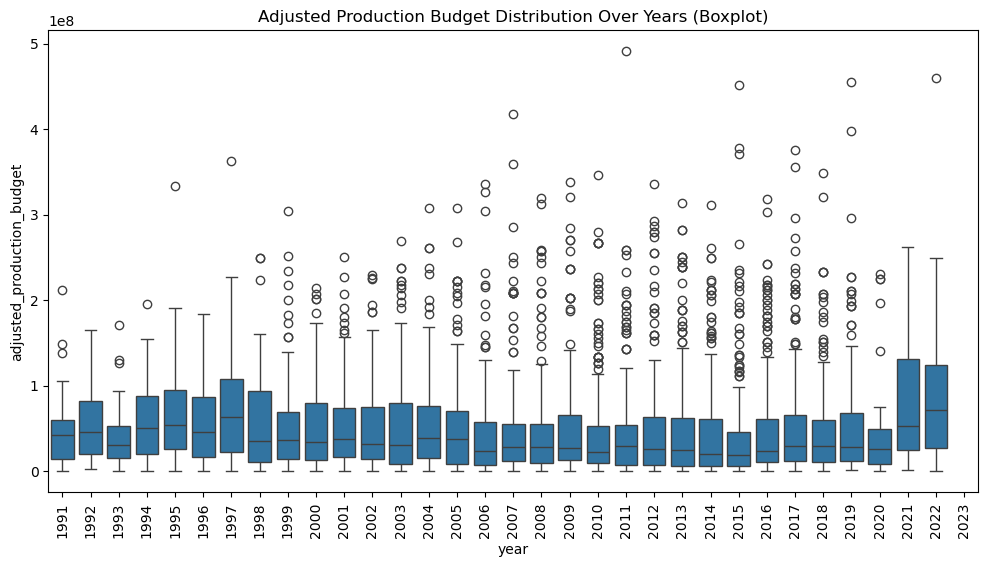

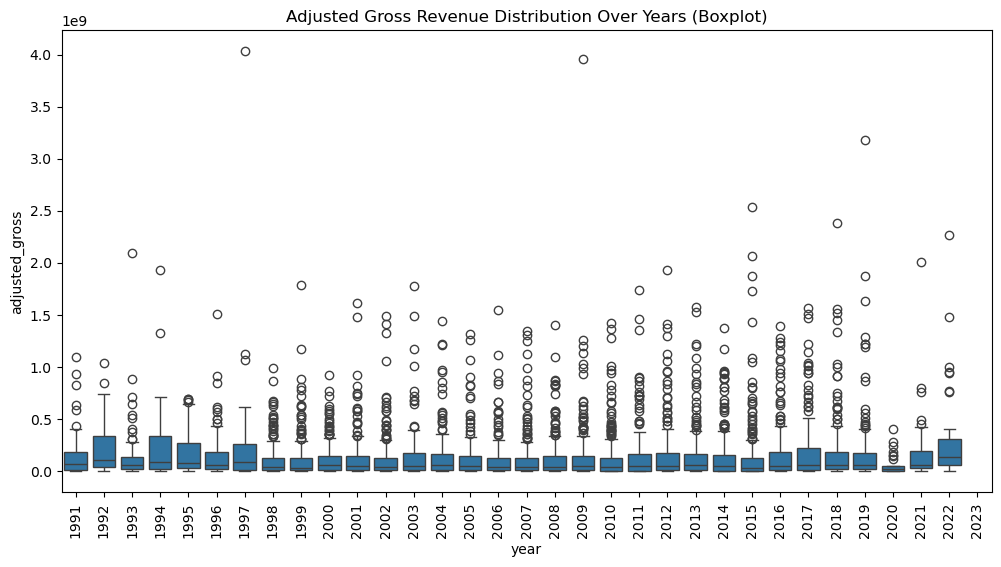

In [166]:
#Visualizing recent budget and gross earnings (since 1990)

filtered_data = money_data[money_data['year'] > 1990]

# Distribution by years with boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='adjusted_production_budget', data=filtered_data)
plt.xticks(rotation=90)  # X eksenindeki yılları net görmek için döndürme
plt.title('Adjusted Production Budget Distribution Over Years (Boxplot)')
plt.show()

# Likewise for Adjusted Gross
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='adjusted_gross', data=filtered_data)
plt.xticks(rotation=90)
plt.title('Adjusted Gross Revenue Distribution Over Years (Boxplot)')
plt.show()

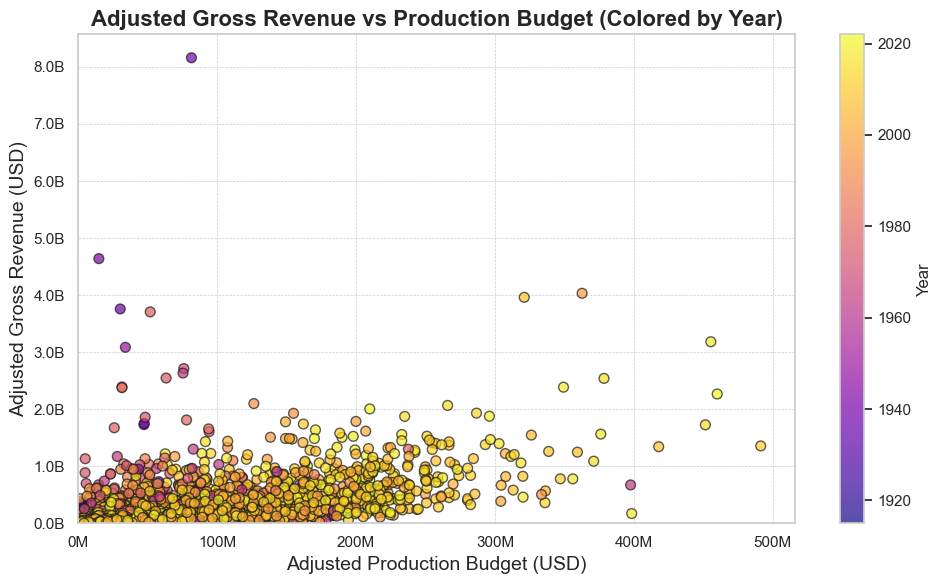

In [171]:

# Set plot style
sns.set_theme(style="whitegrid")

# Scatter plot for Adjusted Domestic Gross vs Adjusted Production Budget
plt.figure(figsize=(10, 6))

# Define the scatter plot with better visual parameters
scatter = plt.scatter(money_data['adjusted_production_budget'],
                      money_data['adjusted_gross'],
                      c=money_data['year'], cmap='plasma', s=50, alpha=0.7, edgecolor='k')

# Add a color bar to indicate the years
cbar = plt.colorbar(scatter)
cbar.set_label('Year')

# Set titles and labels
plt.title('Adjusted Gross Revenue vs Production Budget (Colored by Year)', fontsize=16, fontweight='bold')
plt.xlabel('Adjusted Production Budget (USD)', fontsize=14)
plt.ylabel('Adjusted Gross Revenue (USD)', fontsize=14)

plt.xlim(left=0)
plt.ylim(bottom=0)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#Remove scientific notation

plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x * 1e-6:.0f}M'))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y * 1e-9:.1f}B'))
plt.tight_layout()
plt.show()

These exploratory visualizations of the data emphasize the significant variance in gross earnings and, consequently, in return on investment (ROI). The color scale indicates that more recent films (yellow and light orange) tend to have higher production budgets than older films (purple), reflecting expansion and capitalization of the industry. 

Intercept: -12107272.085855186
Slope: 3.389186292467068
R-squared: 0.6231305193803195


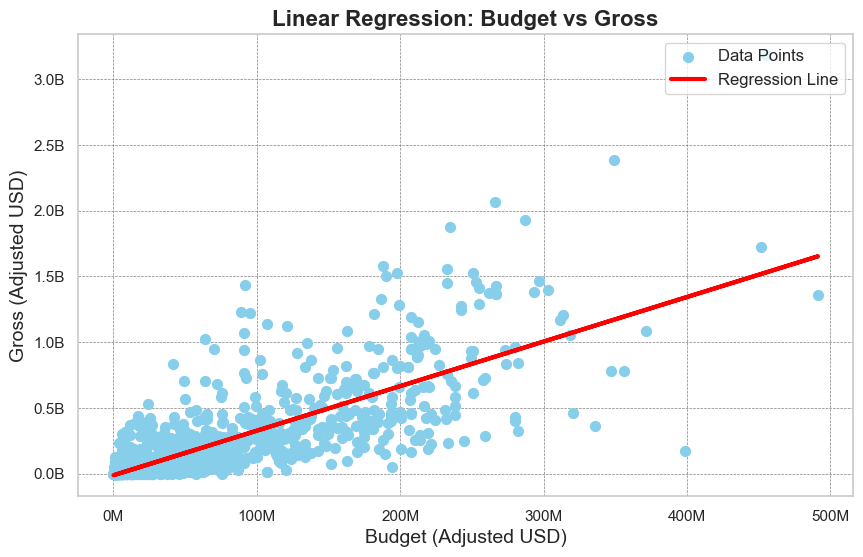

In [170]:
# Select the independent (X) and dependent (y) variables
x = df_clean_movies['adjusted_production_budget'].dropna().values.reshape(-1, 1)
y = df_clean_movies['adjusted_gross']

# Fit the linear regression model
model = LinearRegression()
model.fit(x, y)

# Print the coefficients
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")

# Predict values using the model
y_pred = model.predict(x)
r2 = r2_score(y, y_pred)
print(f"R-squared: {r2}")

# Plot the regression line and data points
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='skyblue', s=50, label='Data Points')
plt.plot(x, y_pred, color='red', linewidth=3, label='Regression Line')
plt.xlabel('Budget (Adjusted USD)', fontsize=14)
plt.ylabel('Gross (Adjusted USD)', fontsize=14)
plt.title('Linear Regression: Budget vs Gross', fontsize=16, fontweight='bold')

# Remove scientific notation from axes
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}M'.format(x / 1e6)))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:,.1f}B'.format(y / 1e9)))

plt.legend(loc='upper right', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

C:\Users\erica\AppData\Local\Temp\ipykernel_14780\453901733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='budget_category', y='ROI', data=budget_analysis, palette='coolwarm', linewidth=2.5, edgecolor='black')


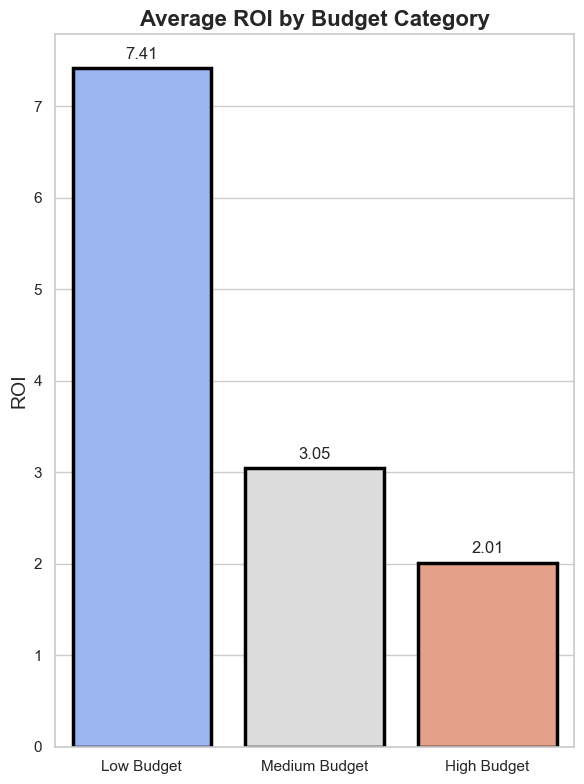

In [173]:
# Create the bar plot
plt.figure(figsize=(6, 8))
sns.barplot(x='budget_category', y='ROI', data=budget_analysis, palette='coolwarm', linewidth=2.5, edgecolor='black')

# Add labels and title
plt.title('Average ROI by Budget Category', fontsize=16, weight='bold')
plt.ylabel('ROI', fontsize=14)
plt.xlabel('', fontsize=14)

# Add data labels on top of bars
for i in range(len(budget_analysis)):
    plt.text(i, budget_analysis['ROI'][i] + 0.1, round(budget_analysis['ROI'][i], 2),
             ha='center', fontsize=12)

# Final adjustments to layout and display
plt.tight_layout()
plt.show()

In [174]:
budget_analysis

,budget_category,ROI
0,Low Budget,7.414915
1,Medium Budget,3.047011
2,High Budget,2.013033


Given the noisy data, the first logical question is: "What is the relationship between budget and gross revenue?" From the model, we observe that for each budget dollar spent, there is an expected gross earning of $3.19, with budget explaining 30% of the variance. However, when analyzing budget categories, we notice that high-budget films have a diminished ROI compared to low-to-medium budget films. Therefore, increasing the budget within reasonable limits would be an effective strategy for maximizing revenue, but managing risk exposure is key - it's more worthwhile to be able to make several low-budget films than to overreach for a higher budget film.

In [175]:
df_clean_movies.columns

Index(['movie_id', 'movie_title', 'original_title', 'year', 'runtime_minutes',
       'genres', 'person_id', 'director_name', 'director_birth_year',
       'director_death_year', 'primary_profession', 'averagerating',
       'numvotes', 'approval_Index', 'Production budget $', 'Domestic gross $',
       'Worldwide gross $', 'adjusted_production_budget', 'adjusted_gross',
       'ROI', 'principal_count'],
      dtype='object')

Approval Index: Intercept = 0.5084804389136273, Coeff = 0.49178144319790973, R-squared = 0.0026641718729424335
Movie Average Rating: Intercept = 2.8710808457125636, Coeff = 0.0034804830699764113, R-squared = 7.922516831460058e-08


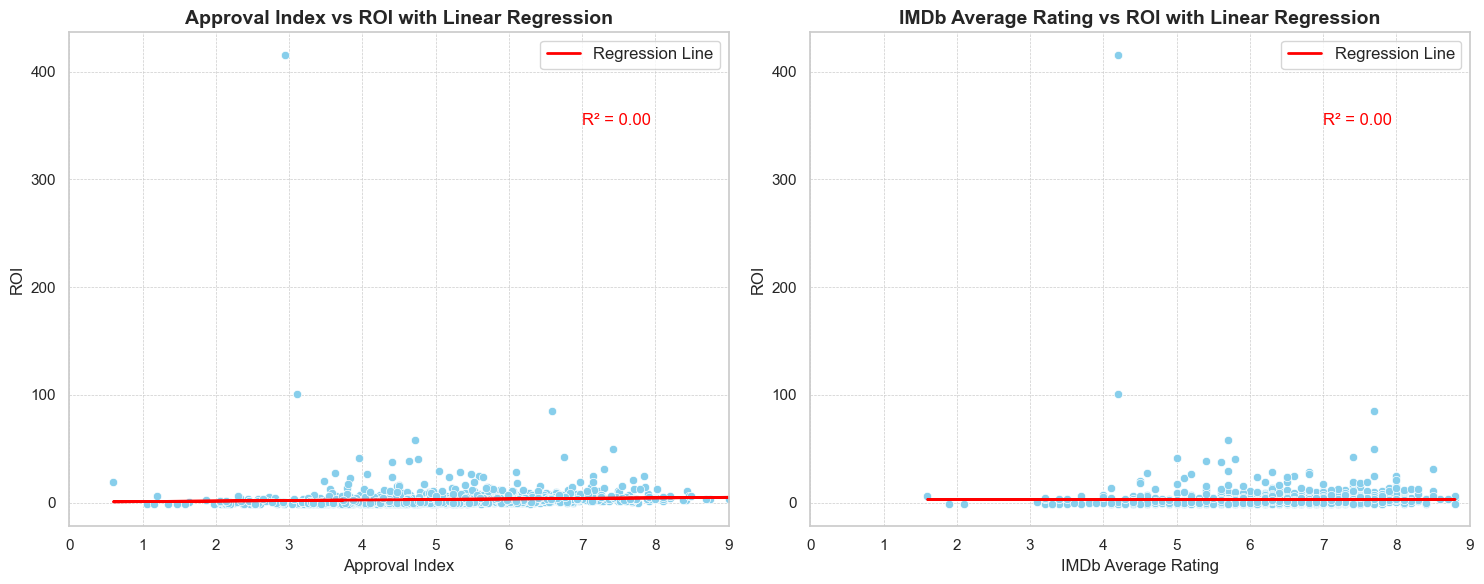

In [177]:
df_filtered = df_clean_movies[['approval_Index', 'ROI']].dropna()
X_approval = df_filtered['approval_Index'].values.reshape(-1, 1)
y = df_filtered['ROI'].values

# Linear regression model for Approval Index
model_approval = LinearRegression()
model_approval.fit(X_approval, y)
r2_approval = model_approval.score(X_approval, y)

# Filter data for Movie Average Rating vs ROI
df_filtered_rating = df_clean_movies[['averagerating', 'ROI']].dropna()
X_rating = df_filtered_rating['averagerating'].values.reshape(-1, 1)
y_rating = df_filtered_rating['ROI'].values

# Linear regression model for Movie Average Rating
model_rating = LinearRegression()
model_rating.fit(X_rating, y_rating)
r2_rating = model_rating.score(X_rating, y_rating)

# Print intercepts, coefficients, and R-squared values
print(f"Approval Index: Intercept = {model_approval.intercept_}, Coeff = {model_approval.coef_[0]}, R-squared = {r2_approval}")
print(f"Movie Average Rating: Intercept = {model_rating.intercept_}, Coeff = {model_rating.coef_[0]}, R-squared = {r2_rating}")

# Visualize the regression lines
plt.figure(figsize=(15, 6))

# Define the common x-axis limits for both plots
x_limits = (0, 9)  # Adjust these limits according to your data

# Subplot for Approval Index vs ROI
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_clean_movies, x='approval_Index', y='ROI', color='skyblue')
plt.plot(X_approval, model_approval.predict(X_approval), color='red', label='Regression Line', linewidth=2)
plt.title('Approval Index vs ROI with Linear Regression', fontsize=14, weight='bold')
plt.xlabel('Approval Index', fontsize=12)
plt.ylabel('ROI', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.text(7, 350, f'R² = {r2_approval:.2f}', fontsize=12, color='red')
plt.xlim(x_limits)  # Set the same x-axis limits for consistency
plt.legend(loc='upper right', fontsize=12)

# Subplot for Movie Average Rating vs ROI
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_clean_movies, x='averagerating', y='ROI', color='skyblue')
plt.plot(X_rating, model_rating.predict(X_rating), color='red', label='Regression Line', linewidth=2)
plt.title('IMDb Average Rating vs ROI with Linear Regression', fontsize=14, weight='bold')
plt.xlabel('IMDb Average Rating', fontsize=12)
plt.ylabel('ROI', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.text(7, 350, f'R² = {r2_rating:.2f}', fontsize=12, color='red')
plt.xlim(x_limits)  # Set the same x-axis limits for consistency
plt.legend(loc='upper right', fontsize=12)

# Tight layout to avoid overlapping of subplots
plt.tight_layout()
plt.show()

Ratings appear to have no effect on ROI.

In [178]:
# Run the ANOVA test on genre 
genre_anova_result = stats.f_oneway(*roi_data)

# Display the results
print(f'ANOVA F-statistic: {genre_anova_result.statistic}, p-value: {genre_anova_result.pvalue}')

ANOVA F-statistic: 5.068370140228647, p-value: 3.3418114642296983e-13



Interpretation:
Since the p-value is less than 0.05, we can reject the null hypothesis. This means that there are significant differences in the average ROI among the genres and some genres likely have better ROI compared to others.

A Tukey HSD test can help us with post-hoc analysis of these differences.

In [184]:
genre_tk_hsd = pairwise_tukeyhsd(df_cleaned_exploded['ROI'], df_cleaned_exploded['genres'], alpha=.05)


<Figure size 1200x800 with 0 Axes>

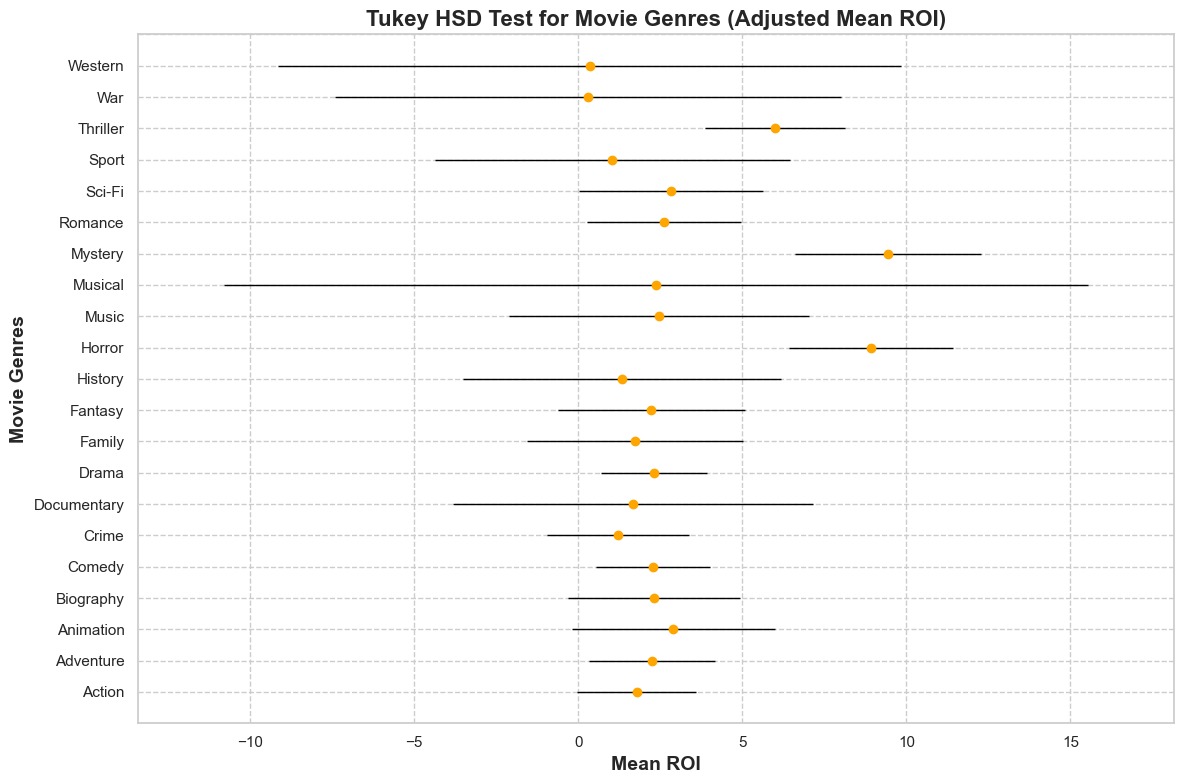

In [185]:
genre_tk_hsd = pairwise_tukeyhsd(df_cleaned_exploded['ROI'], df_cleaned_exploded['genres'], alpha=0.05)


plt.figure(figsize=(12, 8))

genre_tk_hsd.plot_simultaneous(figsize=(12, 8))


lines = plt.gca().lines
for line in lines:
    line.set_color('orange')  
    line.set_linewidth(2)  


points = plt.gca().collections[0]
points.set_edgecolor('black')  
points.set_linewidth(1)  


plt.title('Tukey HSD Test for Movie Genres (Adjusted Mean ROI)', fontsize=16, weight='bold')
plt.xlabel('Mean ROI', fontsize=14, weight='bold')  # Adjusted x label
plt.ylabel('Movie Genres', fontsize=14, weight='bold')

plt.grid(True, linestyle='--', linewidth=1)
plt.tight_layout()


plt.show()

This visualization clearly shows the confidence intervals for ROI differences between various movie genres. It helps pinpoint which genres tend to perform better or worse in terms of ROI. For example, our data shows a high degree of confidence in the mean ROI for horror films. However, some high-performing genres, like musicals, are not as well-represented in the data, so they exhibit wider confidence intervals. Even so, musicals still rank among the genres with the strongest average ROIs and may still also be a good option. Drama represents a third tier with small confidence interval and strong mean ROI as another emminently reasonable choice depending on other production factors.

From the graph, we observe overall that each budget dollar generates an expected gross earning of $3.19, with budget explaining approximately 30% of the variance. However, when analyzing budget categories, we note a diminished ROI for high-budget films compared to low-to-medium budget films. Therefore, increasing the available budget within reasonable limits appears to be a more effective strategy.

In [189]:
# ANOVA test setup for count of principals in a movie
principal_count_roi = [df_clean_movies[df_clean_movies['principal_count'] == count]['ROI'].dropna() for count in list(range(1,11))]

# Run the ANOVA test
pcr_anova_result = stats.f_oneway(*principal_count_roi)

# Display the results
print(f'ANOVA F-statistic: {pcr_anova_result.statistic}, p-value: {pcr_anova_result.pvalue}')

ANOVA F-statistic: 0.11111871191436577, p-value: 0.9994327718926266


Results are significant for p<0.5 so we follow up with a tukey test to determine which numbers of principals perform well.

<Figure size 1200x800 with 0 Axes>

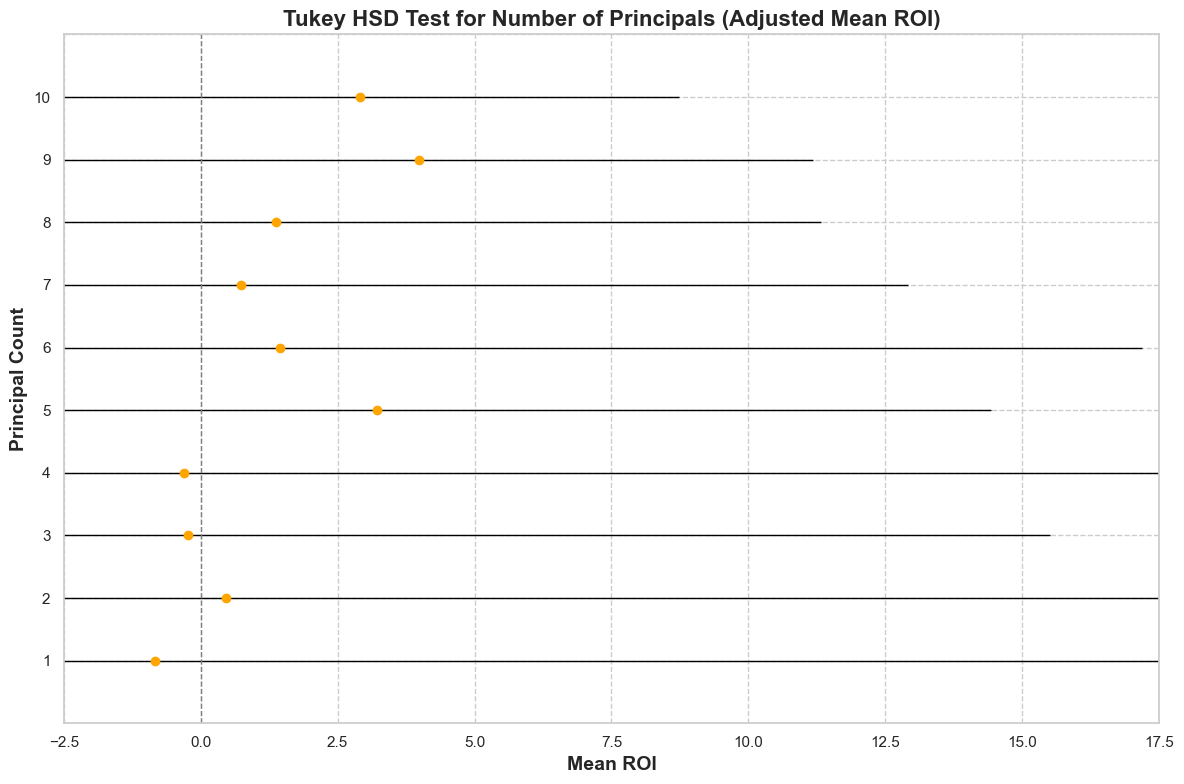

In [187]:
df_clean_filtered = df_clean_movies.dropna(subset=['ROI', 'principal_count'])

# Perform the Tukey HSD test
pcr_tk_hsd = pairwise_tukeyhsd(df_clean_filtered['ROI'], df_clean_filtered['principal_count'], alpha=0.05)


plt.figure(figsize=(12, 8))

# Plot the Tukey HSD results
pcr_tk_hsd.plot_simultaneous(figsize=(12, 8))


lines = plt.gca().lines
for line in lines:
    line.set_color('orange') 
    line.set_linewidth(2)     


points = plt.gca().collections[0]
points.set_edgecolor('black')  
points.set_linewidth(1)        


plt.axvline(0, color='grey', linestyle='--', linewidth=1)

plt.xlim(-2.5, 17.5)
plt.title('Tukey HSD Test for Number of Principals (Mean ROI)', fontsize=16, weight='bold')
plt.xlabel('Mean ROI', fontsize=14, weight='bold')
plt.ylabel('Principal Count', fontsize=14, weight='bold')


plt.grid(True, linestyle='--', linewidth=1)


plt.tight_layout()


plt.show()

This visualization helps identify which specific groups of principal counts perform better or worse in terms of ROI. The confidence intervals allow us to assess which principal counts significantly differ from each other in terms of financial performance. Specifically we see that 2 principals has signficiantly higher mean ROI than 7-10 principlas with 95% confidence, and has the highest mean ROI overall, so it seems likely that a "dynamic duo" can boost a film's appeal, while a large principal cast is more risky. 

In [207]:
top_directors.head(20)

,director_name,ROI,genres_x,adjusted_production_budget,budget_category,movie_count
0,Aneesh Chaganty,84.950053,"Drama,Mystery,Thriller",1.024757e+06,Low Budget,1
1,Nathaniel Davis,68.609409,Horror,7.413009e+04,Low Budget,2
2,Tod Williams,58.170677,Horror,4.004398e+06,Low Budget,1
3,Damien Leone,50.165976,Horror,2.500000e+05,Low Budget,1
4,Bradley Parker,41.411721,"Horror,Mystery,Thriller",1.274210e+06,Low Budget,1
5,Nitesh Tiwari,31.120996,"Action, Action,Biography,Drama",1.151181e+07,Medium Budget,2
6,Barry Jenkins,28.451563,"Horror, Drama, Drama,Romance",5.869757e+06,Medium Budget,3
7,William Lustig,27.571429,"Action,Horror,Thriller, Horror,Thriller",1.186512e+06,Low Budget,2
9,William Brent Bell,22.735758,"Horror, Drama,Horror,Thriller, Horror,Mystery,...",1.314730e+07,Medium Budget,5
10,Jordan Peele,21.215722,"Horror,Mystery,Thriller, Drama, Comedy",1.856064e+07,Medium Budget,4


C:\Users\erica\AppData\Local\Temp\ipykernel_13472\4158770075.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x="movie_count", y="ROI", data=top_directors_sorted, palette="Blues_d", ci=None)
C:\Users\erica\AppData\Local\Temp\ipykernel_13472\4158770075.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x="movie_count", y="ROI", data=top_directors_sorted, palette="Blues_d", ci=None)


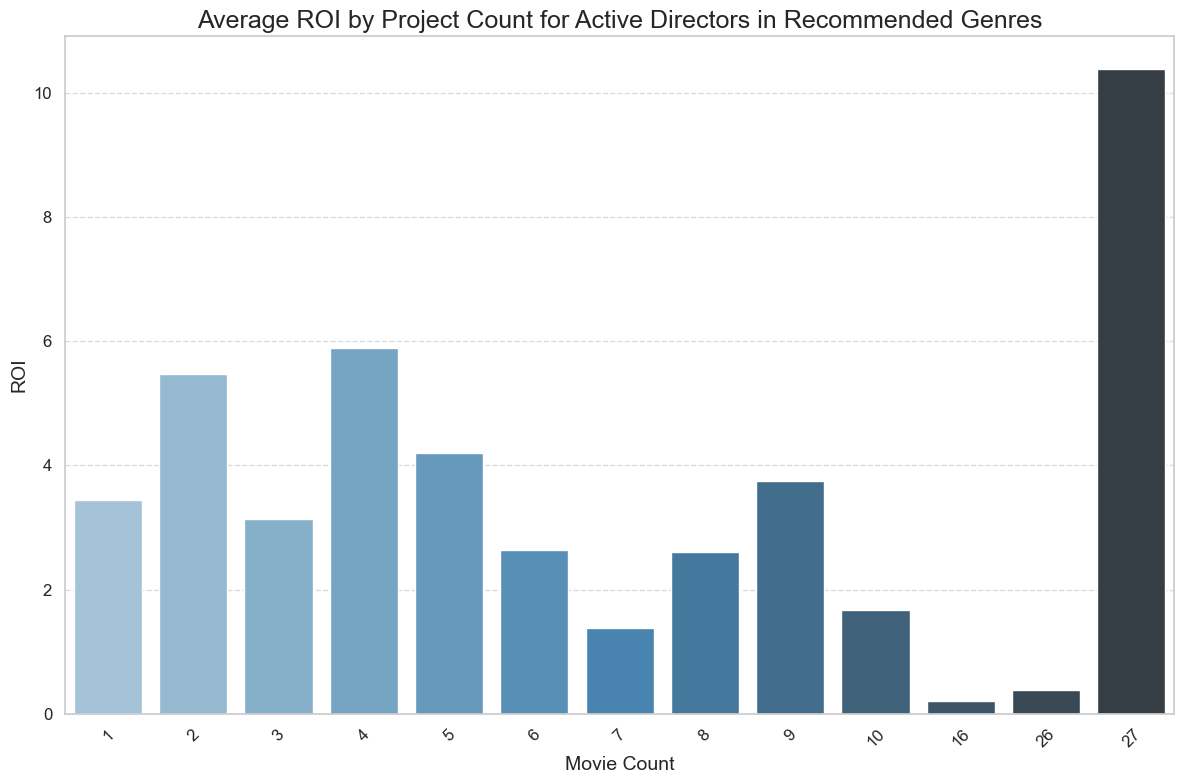

In [208]:
top_directors_clean = top_directors.dropna(subset=['movie_count', 'ROI'])
top_directors_clean = top_directors_clean[np.isfinite(top_directors_clean['movie_count'])]
top_directors_clean = top_directors_clean[np.isfinite(top_directors_clean['ROI'])]


top_directors_sorted = top_directors_clean.sort_values(by='movie_count')


plt.figure(figsize=(12, 8))


bar_plot = sns.barplot(x="movie_count", y="ROI", data=top_directors_sorted, palette="Blues_d", ci=None)


plt.title("Average ROI by Project Count for Active Directors in Recommended Genres", fontsize=18)
plt.xlabel("Movie Count", fontsize=14)
plt.ylabel("ROI", fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

Here we have a list of our top 25 available and affordable high-performing directors (measured by mean ROI) who work in Horror and/or Drama, with helpful annotations on budget category and the number of movies they directed that we have data for. Given the small sample sizes, statistical comparisons like ANOVA or Tukey's test may not provide significant insights. However, this list can serve as a reliable starting point for determining which directors to approach. With confidence in their track record, directors like Jordan Peele, Jeff Wadlow, or Michael Madsen would be ideal partners for any project. 

## Conclusion

- While larger budgets can lead to higher gross earnings, our analysis shows that ROI diminishes as budgets increase. High-budget films tend to offer lower returns compared to low- to medium-budget productions. It's essential to strike a balance—allocate enough resources to ensure quality, but avoid overspending, as the additional costs may not be justified by the returns.

- High ratings, including approval indexes and average ratings, have minimal impact on ROI. Focusing too much on achieving critical acclaim may not be financially beneficial. Instead, prioritize optimizing production costs and investing in genres with a proven track record of profitability to drive financial success.

- Genres such as Horror, Musicals, and Drama consistently deliver higher ROI. Concentrating on these top-performing genres allows filmmakers to maximize returns while minimizing financial risk. Sticking to genres with a strong track record is a more reliable strategy than experimenting with less proven options.

- Films with smaller principal casts, particularly dynamic duos, tend to deliver better ROI than productions with large casts. Large ensembles generally don’t result in higher returns, whereas dynamic duos offer broad appeal and can be produced more efficiently.

- Working with directors who have a successful track record, especially within key genres like Horror, Drama, and Musicals, significantly increases the chances of a high ROI. Directors with experience in low- to medium-budget films bring industry expertise and genre-specific knowledge that align with the financial goals of the project.

## Next Steps

Several features in the IMDB dataset have yet to be thoroughly analyzed, offering significant potential for deeper insights. The next step should involve exploring these untapped features to uncover new patterns and relationships. By combining these features into a more comprehensive model, we can enhance the overall analysis and increase the accuracy of our predictions.

Additionally, incorporating more detailed production elements—such as crew experience, shooting locations, and marketing strategies—alongside economic and cultural context will provide a richer understanding of what drives a movie's success. For example, understanding how cultural trends or economic conditions at the time of release impact box office performance could yield valuable insights.

Expanding the analysis in these ways will allow for more nuanced conclusions and help identify the key factors that contribute to a movie's financial and critical success.

